***Anurag Sharma (24AI91R01)***

In [131]:
# Standard library
import os
import glob
import random
import zipfile

# Numerical and image processing
import numpy as np
from PIL import Image

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary

Question 1

Load the brain tumor MRI image dataset from Kaggle: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhranta/brain-tumor-detection-mri")

print("Path to dataset files:", path)

100%|██████████| 64.3M/64.3M [00:00<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhranta/brain-tumor-detection-mri/versions/1


In [132]:
folder = 'Brain_Tumor_Detection'
os.listdir(os.path.join(path, folder))

['pred', 'no', 'yes']

In [133]:
# ['pred', 'no', 'yes']
label_folders = os.listdir(os.path.join(path, folder))
label_folders

['pred', 'no', 'yes']

In [136]:
image_paths = []
labels = []

for label_folder in label_folders:
  label_path = os.path.join(path, folder, label_folder)
  image_files = glob.glob(os.path.join(label_path, '*.jpg'))
  for image_file in image_files:
    image_paths.append(image_file)
    labels.append(label_folder)

In [137]:
positive_images = [image_paths[i] for i in range(len(image_paths)) if labels[i] == 'yes']
negative_images = [image_paths[i] for i in range(len(image_paths)) if labels[i] == 'no']

Question 2

Show samples of images from the positive (with tumor) and negative (without tumor) classes.

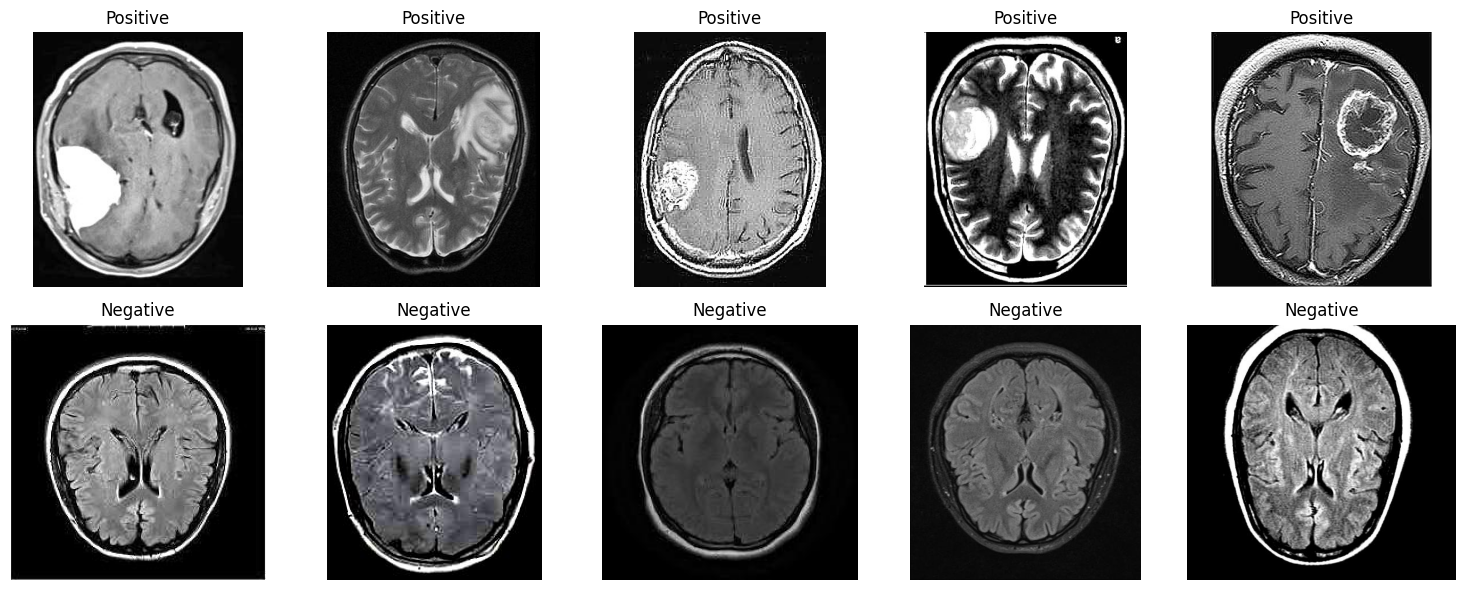

In [138]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    img = mpimg.imread(positive_images[i])
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('Positive')
for i in range(5):
    img = mpimg.imread(negative_images[i])
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Negative')

plt.tight_layout()
plt.show()

Question 3

Divide the negative class into training and test sets (80%-20%). Sample equal number of test set images from the positive set (images with tumor)

In [139]:
# Split the negative class into training and testing sets
negative_train, negative_test = train_test_split(negative_images, test_size=0.2, random_state=20)

# Sample an equal number of positive images for the test set
positive_test = random.sample(positive_images, len(negative_test))

# Combine the training and testing sets
train_images = negative_train + positive_images # All positive images in training
test_images = negative_test + positive_test

In [140]:
# Create corresponding labels for the combined sets
train_labels = ['no'] * len(negative_train) + ['yes'] * len(positive_images)
test_labels = ['no'] * len(negative_test) + ['yes'] * len(positive_test)

print("Number of training images:", len(train_images))
print("Number of testing images:", len(test_images))
print("Number of positive images in training set:", train_labels.count('yes'))
print("Number of negative images in training set:", train_labels.count('no'))
print("Number of positive images in testing set:", test_labels.count('yes'))
print("Number of negative images in testing set:", test_labels.count('no'))

Number of training images: 2700
Number of testing images: 600
Number of positive images in training set: 1500
Number of negative images in training set: 1200
Number of positive images in testing set: 300
Number of negative images in testing set: 300


Question 4

Design an autoencoder model with the U-Net like architecture (without skip connections) to learn the distribution of the negative class, i.e. normal images with no brain tumor (follow the same number type and number of layers as in lab demo, and change only the number of kernels in the layers closest to latent space to ensure the total model parameters to be in the range of 25,000 to 28,000). Show the model summary and number of parameters of the model.

In [170]:
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),   # 1x128x128 -> 8x128x128
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> 8x64x64

            nn.Conv2d(8, 16, kernel_size=3, padding=1),  # -> 16x64x64
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> 16x32x32

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> 32x16x16

            nn.Conv2d(32, 43, kernel_size=3, padding=1), # -> 43x16x16
            nn.ReLU(),
            nn.MaxPool2d(2)                              # -> 43x8x8 (latent space)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(43, 32, kernel_size=2, stride=2), # -> 32x16x16
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), # -> 16x32x32
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),  # -> 8x64x64
            nn.ReLU(),

            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),   # -> 1x128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetAutoencoder().to(device)

# Print model summary
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]              80
              ReLU-2          [-1, 8, 128, 128]               0
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
              ReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
              ReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 43, 16, 16]          12,427
             ReLU-11           [-1, 43, 16, 16]               0
        MaxPool2d-12             [-1, 43, 8, 8]               0
  ConvTranspose2d-13           [-1, 32, 16, 16]           5,536
             ReLU-14           [-1, 32,

In [172]:
# num of params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 26468


Question 5

Train the autoencoder model on the training set using reconstruction loss and Adam optimizer to learn reconstruction of the negative class from the latent representation. Show the variation of the loss with training progress.

In [173]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),         # Convert to tensor
])

In [174]:
train_data = BrainTumorDataset(train_images, train_labels, transform=transform)
test_data = BrainTumorDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Epoch 1, Loss: 0.1213
Epoch 2, Loss: 0.0370
Epoch 3, Loss: 0.0275
Epoch 4, Loss: 0.0252
Epoch 5, Loss: 0.0239
Epoch 6, Loss: 0.0233
Epoch 7, Loss: 0.0227
Epoch 8, Loss: 0.0222
Epoch 9, Loss: 0.0216
Epoch 10, Loss: 0.0210


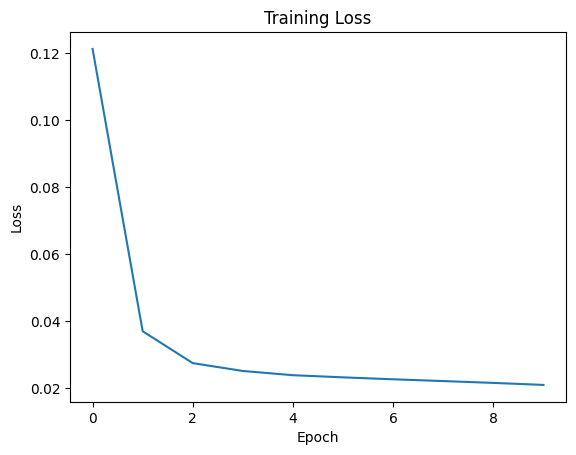

In [175]:
# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Question 6

Use the trained autoencoder to perform reconstruction of the test set samples from both the positive and negative classes.

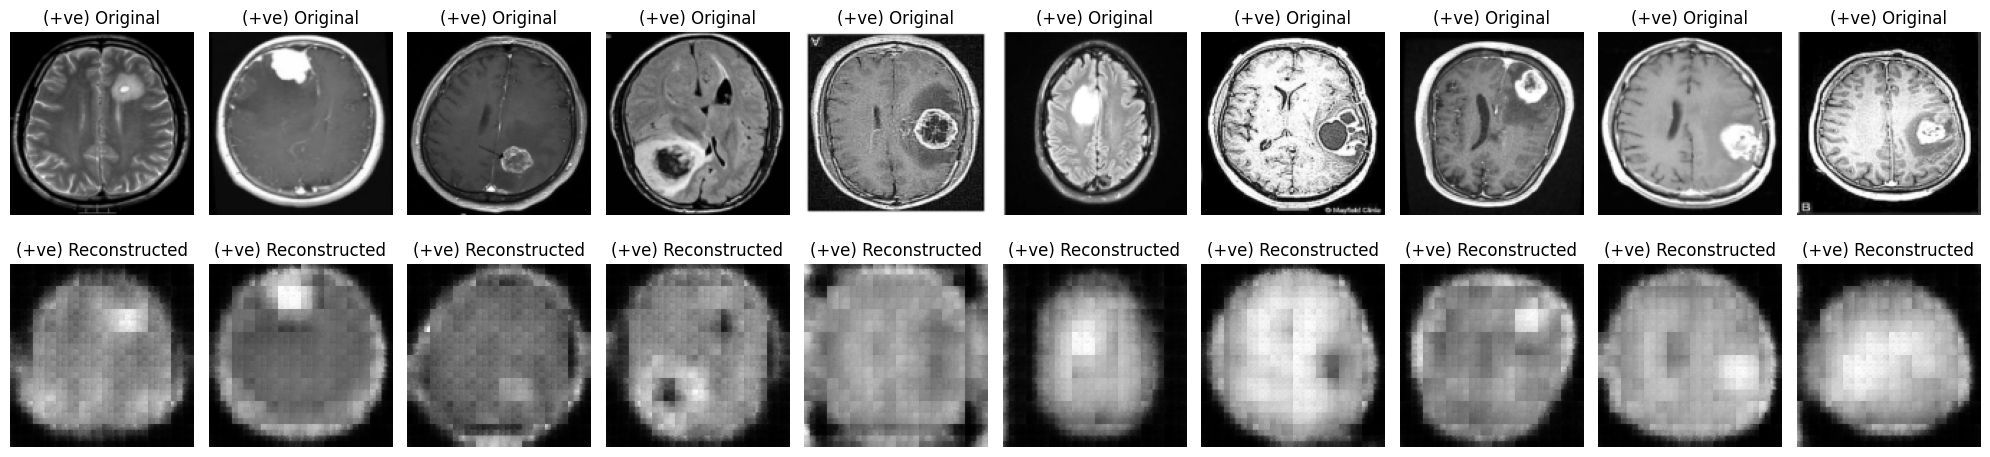

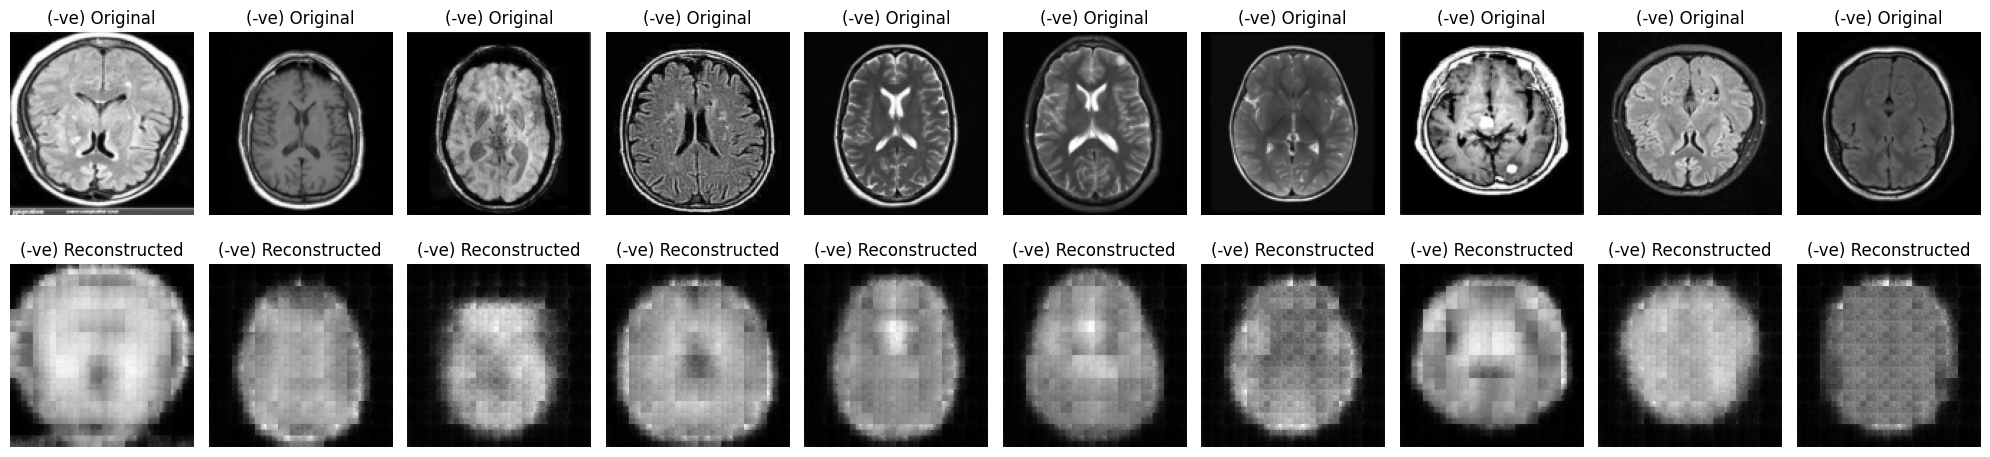

In [176]:
# Reconstruction
positive_test_reconstructions = []
negative_test_reconstructions = []

model.eval()  # evaluation mode
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs = model(inputs)

        for i in range(len(labels)):
          if labels[i] == 'yes':
            positive_test_reconstructions.append((inputs[i].cpu(), outputs[i].cpu()))
          else:
            negative_test_reconstructions.append((inputs[i].cpu(), outputs[i].cpu()))

# Show original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i in range(10):
    axes[0, i].imshow(positive_test_reconstructions[i][0].squeeze(0), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('(+ve) Original')

    axes[1, i].imshow(positive_test_reconstructions[i][1].squeeze(0), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('(+ve) Reconstructed')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i in range(10):
    axes[0, i].imshow(negative_test_reconstructions[i][0].squeeze(0), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('(-ve) Original')

    axes[1, i].imshow(negative_test_reconstructions[i][1].squeeze(0), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('(-ve) Reconstructed')

plt.tight_layout()
plt.show()

Question 7

Show the distribution of the reconstruction losses on the positive and negative classes. Based on this distribution, choose an appropriate value of the threshold to separate the positive and negative classes.

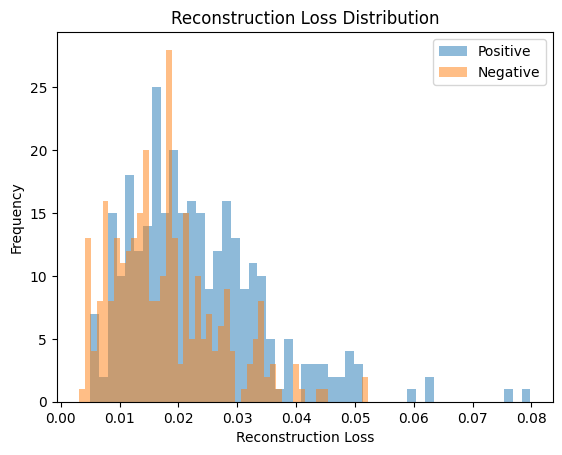

The threshold for anomaly detection is: 0.02525385245680809


In [181]:
# Calculate reconstruction losses
positive_losses = [criterion(recon, img).item() for img, recon in positive_test_reconstructions]
negative_losses = [criterion(recon, img).item() for img, recon in negative_test_reconstructions]

# Plotting the distributions
plt.hist(positive_losses, bins=50, alpha=0.5, label='Positive')
plt.hist(negative_losses, bins=50, alpha=0.5, label='Negative')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Reconstruction Loss Distribution')
plt.show()

threshold = np.percentile(negative_losses, 80)
print(f"The threshold for anomaly detection is: {threshold}")

Question 8

Report the accuracy, precision and recall on the test set using this chosen threshold.

In [182]:
# Predict labels based on the threshold
predictions = [1 if loss > threshold else 0 for loss in positive_losses + negative_losses]
true_labels = [1] * len(positive_losses) + [0] * len(negative_losses)

# Calculate metrics
report = classification_report(true_labels, predictions, target_names=['Positive', 'Negative'], output_dict=True)
accuracy = accuracy_score(true_labels, predictions)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5833
Precision: 0.6026
Recall: 0.5833


Question 9

Now, repeat the same experiment using a VAE (show the model summary and number of parameters of the model) to detect the a anomaly instead of an AE, i.e. design a VAE (follow the same number type and number of layers as in lab demo, and change only the number of kernels in the layers closest to latent space to ensure the total model parameters to be in the range of 25,000 to 28,000) and the corresponding loss (reconstruction + KL-divergence), and train it on the negative class using Adam. Show the variation of the loss with the training progress.

In [183]:
class CustomVAE(nn.Module):
    def __init__(self, input_channels=1, out_channels=1, num_kernels=4):
        super().__init__()

        self.encode_conv_1_1 = nn.Conv2d(input_channels, num_kernels, 3, 1, 1, padding_mode='replicate')
        self.encode_conv_1_2 = nn.Conv2d(num_kernels, num_kernels, 3, 1, 1, padding_mode='replicate')

        self.encode_conv_2_1 = nn.Conv2d(num_kernels, num_kernels*2, 3, 1, 1, padding_mode='replicate')
        self.encode_conv_2_2 = nn.Conv2d(num_kernels*2, num_kernels*2, 3, 1, 1, padding_mode='replicate')

        self.encode_conv_3_1 = nn.Conv2d(num_kernels*2, num_kernels*4, 3, 1, 1, padding_mode='replicate')
        self.encode_conv_3_2 = nn.Conv2d(num_kernels*4, num_kernels*4, 3, 1, 1, padding_mode='replicate')

        bottleneck_kernels = num_kernels * 6  # Adjusted for parameter control

        self.bottleneck_conv_1 = nn.Conv2d(num_kernels*4, bottleneck_kernels, 3, 1, 1, padding_mode='replicate')
        self.bottleneck_conv_2_mu = nn.Conv2d(bottleneck_kernels, bottleneck_kernels, 3, 1, 1, padding_mode='replicate')
        self.bottleneck_conv_2_sigma = nn.Conv2d(bottleneck_kernels, bottleneck_kernels, 3, 1, 1, padding_mode='replicate')

        self.decode_transpose_conv_1 = nn.ConvTranspose2d(bottleneck_kernels, num_kernels*4, 2, 2)
        self.decode_conv_1_1 = nn.Conv2d(num_kernels*4, num_kernels*4, 3, 1, 1, padding_mode='replicate')
        self.decode_conv_1_2 = nn.Conv2d(num_kernels*4, num_kernels*4, 3, 1, 1, padding_mode='replicate')

        self.decode_transpose_conv_2 = nn.ConvTranspose2d(num_kernels*4, num_kernels*2, 2, 2)
        self.decode_conv_2_1 = nn.Conv2d(num_kernels*2, num_kernels*2, 3, 1, 1, padding_mode='replicate')
        self.decode_conv_2_2 = nn.Conv2d(num_kernels*2, num_kernels*2, 3, 1, 1, padding_mode='replicate')

        self.decode_transpose_conv_3 = nn.ConvTranspose2d(num_kernels*2, num_kernels, 2, 2)
        self.decode_conv_3_1 = nn.Conv2d(num_kernels, num_kernels, 3, 1, 1, padding_mode='replicate')
        self.decode_conv_3_2 = nn.Conv2d(num_kernels, out_channels, 3, 1, 1, padding_mode='replicate')

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(2)

    def encode(self, x):
        x = self.relu(self.encode_conv_1_1(x))
        x = self.relu(self.encode_conv_1_2(x))
        x = self.maxpool(x)
        x = self.relu(self.encode_conv_2_1(x))
        x = self.relu(self.encode_conv_2_2(x))
        x = self.maxpool(x)
        x = self.relu(self.encode_conv_3_1(x))
        x = self.relu(self.encode_conv_3_2(x))
        x = self.maxpool(x)
        x = self.relu(self.bottleneck_conv_1(x))
        mu = self.bottleneck_conv_2_mu(x)
        log_var = self.bottleneck_conv_2_sigma(x)
        return mu, log_var

    def decode(self, z):
        x = self.relu(self.decode_transpose_conv_1(z))
        x = self.relu(self.decode_conv_1_1(x))
        x = self.relu(self.decode_conv_1_2(x))
        x = self.relu(self.decode_transpose_conv_2(x))
        x = self.relu(self.decode_conv_2_1(x))
        x = self.relu(self.decode_conv_2_2(x))
        x = self.relu(self.decode_transpose_conv_3(x))
        x = self.relu(self.decode_conv_3_1(x))
        x = self.sigmoid(self.decode_conv_3_2(x))
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_recon = self.decode(z)
        return x_recon, mu, log_var

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomVAE().to(device)

# Print model summary
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 64, 64]              40
              ReLU-2            [-1, 4, 64, 64]               0
            Conv2d-3            [-1, 4, 64, 64]             148
              ReLU-4            [-1, 4, 64, 64]               0
         MaxPool2d-5            [-1, 4, 32, 32]               0
            Conv2d-6            [-1, 8, 32, 32]             296
              ReLU-7            [-1, 8, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             584
              ReLU-9            [-1, 8, 32, 32]               0
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,168
             ReLU-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]           2,320
             ReLU-14           [-1, 16,

In [184]:
def vae_loss(output, target, mu, log_var, beta=1.5):
  recon_criterion = nn.MSELoss()
  recon_loss = recon_criterion(output, target)
  kl_div_loss = torch.sum(0.5 * (log_var.exp() + mu.pow(2) - 1.0 - log_var))

  return recon_loss + (beta * kl_div_loss), recon_loss, (beta * kl_div_loss)

Epoch 1, Loss: 26.1034
Epoch 2, Loss: 0.0750
Epoch 3, Loss: 0.0687
Epoch 4, Loss: 0.0658
Epoch 5, Loss: 0.0648
Epoch 6, Loss: 0.0634
Epoch 7, Loss: 0.0619
Epoch 8, Loss: 0.0611
Epoch 9, Loss: 0.0607
Epoch 10, Loss: 0.0605


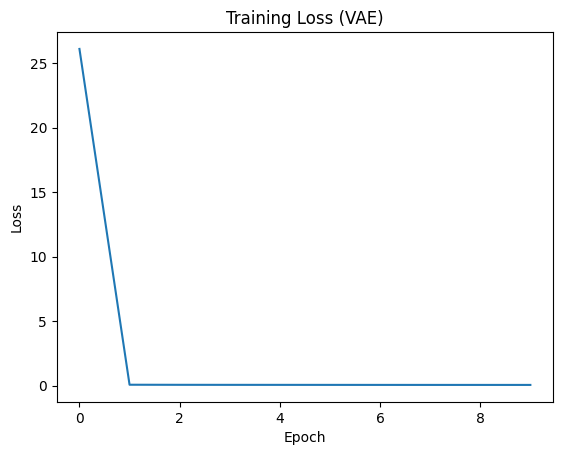

In [185]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs, mu, log_var = model(inputs)
        loss, recon_loss, kl_loss = vae_loss(outputs, inputs, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (VAE)')
plt.show()

Question 10

With the trained VAE model, compute the overall loss (reconstruction + KLD) on all samples in the test set (for both positive and negative classes).

In [186]:
# calculating overall loss (reconstruction + KLD) on the test set
model.eval()
total_loss = 0
total_recon_loss = 0
total_kld_loss = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs, mu, log_var = model(inputs)

        loss, recon_loss, kld_loss = vae_loss(outputs, inputs, mu, log_var)
        total_loss += loss.item() * inputs.size(0)
        total_recon_loss += recon_loss.item() * inputs.size(0)
        total_kld_loss += kld_loss.item() * inputs.size(0)

avg_loss = total_loss / len(test_data)
avg_recon_loss = total_recon_loss / len(test_data)
avg_kld_loss = total_kld_loss / len(test_data)

print(f"Average overall loss: {avg_loss}")
print(f"Average reconstruction loss: {avg_recon_loss}")
print(f"Average KLD loss: {avg_kld_loss}")

Average overall loss: 0.059564433594544726
Average reconstruction loss: 0.05822437673807144
Average KLD loss: 0.0013400569853062431


Question 11

Show the distribution of the losses for the positive and negative classes, and using these two distributions, choose a suitable value of the loss threshold that could be used to detect the anomaly (i.e. brain tumor).

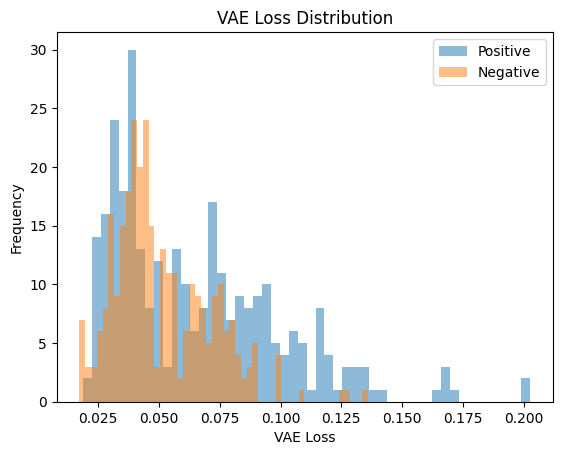

The threshold for anomaly detection (VAE) is: 0.06857849657535553


In [187]:
# Calculate reconstruction losses for VAE
positive_vae_losses = []
negative_vae_losses = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs, mu, log_var = model(inputs)
        # Calculate loss for each sample in the batch
        for j in range(inputs.size(0)):
            sample_loss, _, _ = vae_loss(outputs[j].unsqueeze(0), inputs[j].unsqueeze(0), mu[j].unsqueeze(0), log_var[j].unsqueeze(0))
            if labels[j] == 'yes':
                positive_vae_losses.append(sample_loss.item())
            else:
                negative_vae_losses.append(sample_loss.item())

# Plotting the distributions for VAE
plt.hist(positive_vae_losses, bins=50, alpha=0.5, label='Positive')
plt.hist(negative_vae_losses, bins=50, alpha=0.5, label='Negative')
plt.xlabel('VAE Loss')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('VAE Loss Distribution')
plt.show()

vae_threshold = np.percentile(negative_vae_losses, 80)
print(f"The threshold for anomaly detection (VAE) is: {vae_threshold}")

Question 12

Report the accuracy, precision and recall on the test set using this chosen threshold for VAE.

In [188]:
# Predict labels based on the VAE threshold
vae_predictions = [1 if loss > vae_threshold else 0 for loss in positive_vae_losses + negative_vae_losses]
vae_true_labels = [1] * len(positive_vae_losses) + [0] * len(negative_vae_losses)

# Calculate metrics for VAE
vae_report = classification_report(vae_true_labels, vae_predictions, target_names=['Positive', 'Negative'], output_dict=True)
vae_accuracy = accuracy_score(vae_true_labels, vae_predictions)
vae_precision = vae_report['macro avg']['precision']
vae_recall = vae_report['macro avg']['recall']

print(f"VAE Accuracy: {vae_accuracy:.4f}")
print(f"VAE Precision: {vae_precision:.4f}")
print(f"VAE Recall: {vae_recall:.4f}")

VAE Accuracy: 0.6133
VAE Precision: 0.6317
VAE Recall: 0.6133


Question 13

Which model (AE or VAE) performed better in detecting the anomaly? Explain your answer.

The Autoencoder (AE) architecture is a U-Net-based autoencoder with convolutional layers in the encoder, followed by transposed convolutions in the decoder. The network progressively down-samples the input image through pooling and then reconstructs it back to its original size using transposed convolutions. On the other hand, the Variational Autoencoder (VAE) employs a probabilistic approach with a bottleneck layer generating a latent variable distribution (mean and variance) for encoding, and then uses the reparameterization trick to sample from this distribution. The decoder reconstructs the input image from the latent variable. Comparing the metrics, the VAE shows superior performance with higher accuracy, precision, and recall, likely due to its probabilistic nature, which provides more flexibility in modeling uncertainties, while the AE might struggle to capture such variations effectively.